In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

# pyomo
import importlib
import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [7]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

data.loc[:,'hour'] = pd.to_datetime(data['settlement_date']).dt.hour

# select the main columns for the intial testing
data_subsample = data[['temperature', 'hour', 'nd']]

t = jnp.linspace(0., 1., data_subsample.shape[0])

def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

# interpolate the whole dataset
cs_temp = CubicSpline(t, data_subsample['temperature'])
cs_hour = CubicSpline(t, data_subsample['hour'])
cs_nd = CubicSpline(t, data_subsample['nd'])

#-------------------------------------SPLIT AND DEFINITIONS-------------------------------------

split, end = 100, 200
#split, end = 200, 400

t_train = t[:split]
t_test = t[split:end]

# RESAMPLE TO OBTAIN THE CHEBYSHEV NODES
x_train_cheb = generate_chebyshev_nodes(t_train.shape[0], 0, t_train.max())

y_train_temp = cs_temp(x_train_cheb)
y_train_hour = cs_hour(x_train_cheb)
y_train_nd = cs_nd(x_train_cheb)

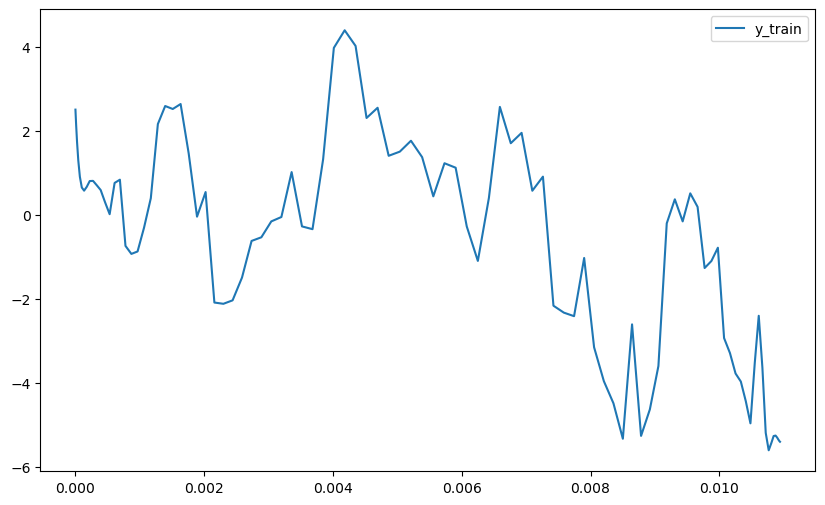

In [8]:
plt.figure(figsize=(10, 6))
#plt.plot(t, data_subsample['temperature'], color='red', label='Original Data')
plt.plot(x_train_cheb, y_train_temp, label='y_train')
plt.plot(t[:100], y_train_temp, label='y_train')

plt.legend()
plt.show()

### split, end defitions

In [627]:
X_train = np.vstack([y_train_temp, y_train_hour]).T
print(X_train.shape)
X_train = pd.DataFrame(X_train, columns=['temperature', 'hour'])
y_train = pd.DataFrame(y_train_nd)

(100, 2)


In [628]:
data_test = data_subsample[split:end]

X_test = data_test[['temperature', 'hour']]
y_test = data_test['nd']

In [629]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [630]:
t_test.shape

(100,)

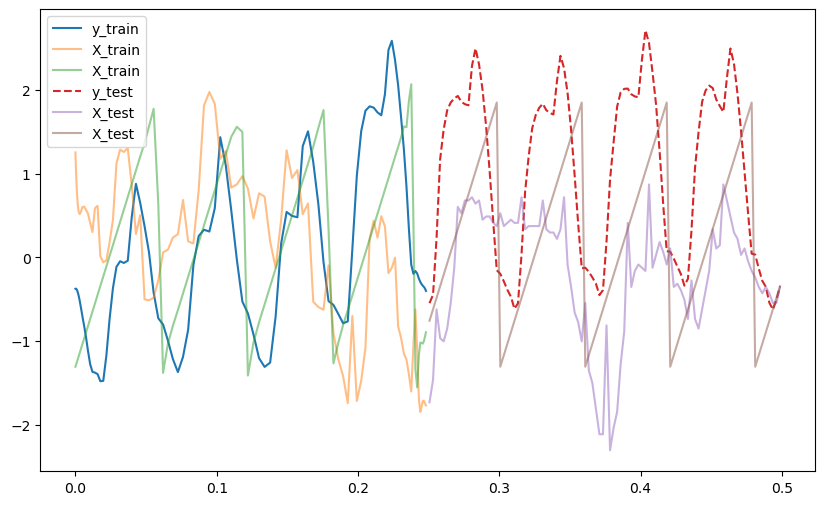

In [631]:
plt.figure(figsize=(10, 6))
#plt.plot(t, data_subsample['temperature'], color='red', label='Original Data')
plt.plot(x_train_cheb, y_train_scaled, label='y_train')
plt.plot(x_train_cheb, X_train_scaled, label='X_train', alpha = 0.5)

plt.plot(t_test, y_test_scaled, label='y_test', ls = '--')
plt.plot(t_test, X_test_scaled, label='X_test', alpha = 0.5)

plt.legend()
plt.show()

In [632]:
weights = compute_weights(x_train_cheb)
D = np.array(lagrange_derivative(x_train_cheb, weights))

In [633]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

tau = 1
m = 3
embeddings = create_delayed_embeddings(y_train_scaled, tau, m)
print(embeddings.shape)

(97, 3)


`updated version with decorators`

In [634]:
"""import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo"""

`initial model version`

In [635]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

### train the model

In [643]:
offset = m*tau
layer_widths = [1 + 2, 30, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-6, 
          "dual_inf_tol": 1e-10, 
          "compl_inf_tol": 1e-10,
          "constr_viol_tol": 1e-10, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-4,
          "acceptable_constr_viol_tol": 1e-1,
          "acceptable_dual_inf_tol": 1e-1,
          "acceptable_compl_inf_tol": 1e-1,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # "mu_strategy": 'adaptive', 
          "check_derivatives_for_naninf": 'yes',
          "max_iter": 10000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_train_scaled[offset : split]), # y
                           np.array(x_train_cheb[offset : split]), # t
                           np.array(D[offset : split, offset : split]),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(y_train_scaled[offset : split]), 
                           penalty_lambda_reg = 0.0001, 
                           penalty_lambda_input = 0.01,
                           constraint_penalty = 1e-5,  
                           
                           extra_input = np.array(X_train_scaled[offset : split]), # X
                           w_init_method = 'xavier', params = params
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-06
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_tol=0.0001
acceptable_constr_viol_tol=0.1
acceptable_dual_inf_tol=0.1
acceptable_compl_inf_tol=0.1
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
check_derivatives_for_naninf=yes
max_iter=10000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    23808
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    19604

Total number of variables.....................

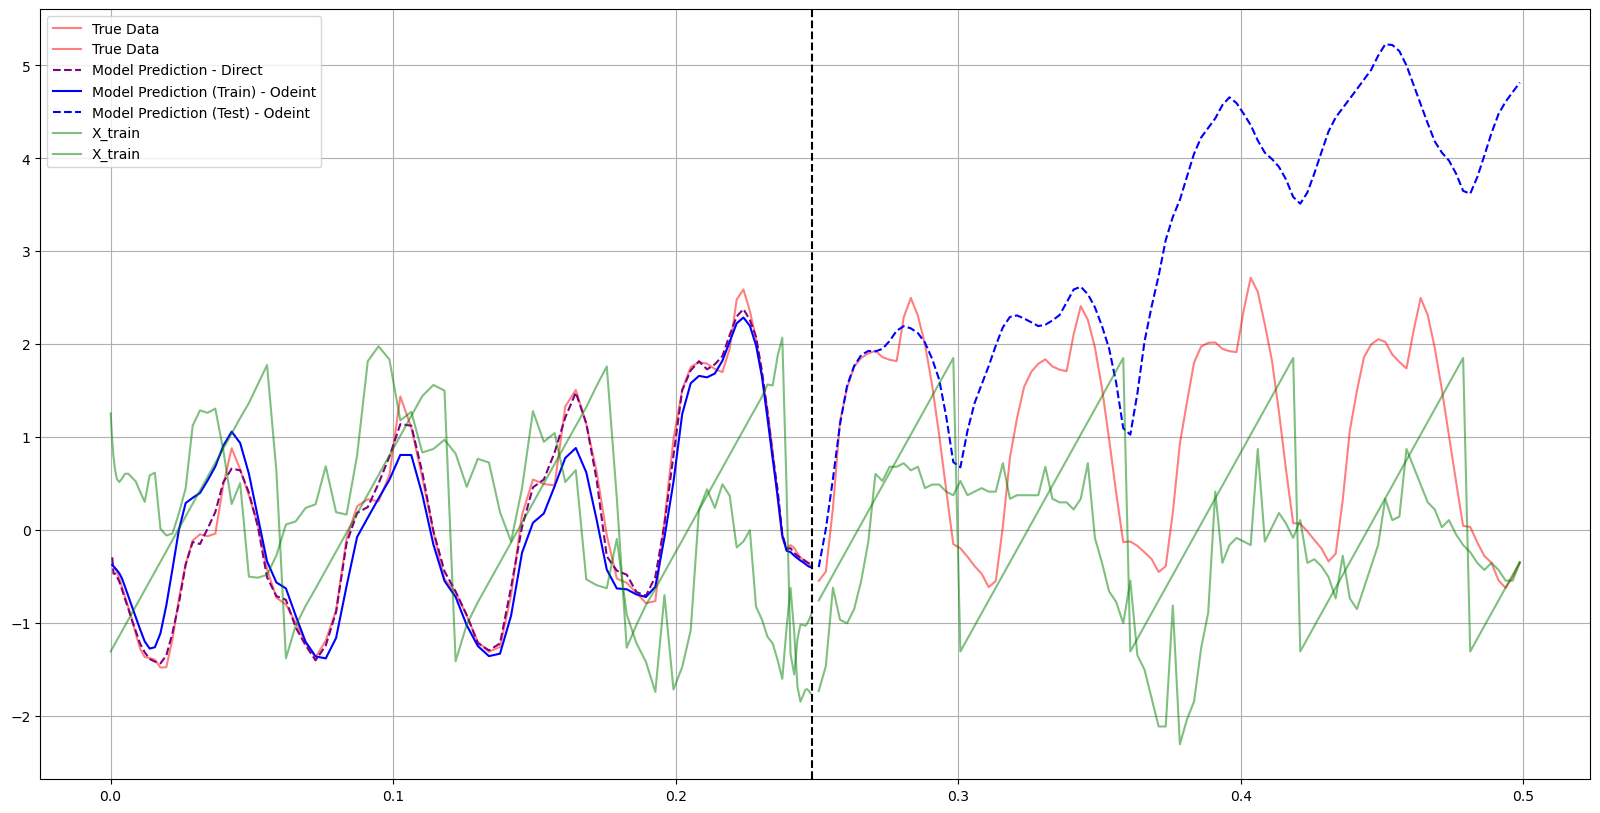

In [644]:
# train
y_init = y_train_scaled[offset : split][0]
t_train = x_train_cheb[offset : split]
extra_args = np.array(X_train_scaled[offset : split])
y_pred = ode_model.neural_ode(y_init, t_train, (extra_args, t_train))

# test
y_init_test = y_pred[-1]
extra_args = np.array(X_test_scaled)
y_pred_test = ode_model.neural_ode(y_init_test, t_test, (extra_args, t_test))


plt.figure(figsize=(20, 10))
plt.plot(x_train_cheb[offset : split], y_train_scaled[offset : split], 'r', label='True Data', alpha = 0.5)
plt.plot(t_test, y_test_scaled, 'r', label='True Data', alpha = 0.5)

plt.plot(x_train_cheb[offset : split], u_model, 'purple', label='Model Prediction - Direct', ls = '--')
plt.plot(t_train, y_pred, 'b', label='Model Prediction (Train) - Odeint')
plt.plot(t_test, y_pred_test, 'b', label='Model Prediction (Test) - Odeint', ls = '--')

plt.plot(x_train_cheb, X_train_scaled, 'g', label='X_train', alpha = 0.5)
plt.plot(t_test, X_test_scaled, 'g', alpha = 0.5)

plt.axvline(x = x_train_cheb[-1], color = 'black', ls = '--')

plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

In [164]:
t_new = x_train_cheb[offset : split]
t_new.shape
X_train_scaled[offset : split].shape

(97, 2)

In [167]:
X_train_scaled[offset : split]

,temperature,hour
3,0.959727,-1.277286
4,0.791652,-1.253379
5,0.642722,-1.222682
6,0.544745,-1.185226
7,0.516285,-1.141050
...,...,...
95,-1.732811,-0.970897
96,-1.751552,-0.938147
97,-1.763682,-0.914371
98,-1.769392,-0.900562


In [ ]:
def neural_ode(self, params, y0, t, state, extra_args=None): 
    results = []    
       
    def func(y, t, args):
        input = jnp.atleast_1d(y)
        
        if not self.time_invariant:
            input = jnp.append(input, t)
            
        if args is not None:
            extra_inputs, t_all = args
            
            if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
                # after confirming that extra inputs is an array
                # there are 2 further options to consider:
                # multiple datapoints and multiple features
                
                if extra_inputs.ndim == 2:
                    # we have multiple datapoints
                    index = jnp.argmin(jnp.abs(t_all - t))
                    for extra_input in extra_inputs[index]:
                            input = jnp.append(input, extra_input)
                            
                elif extra_inputs.ndim == 1:
                    # we have a single datapoint so no need to slice the index
                    for extra_input in extra_inputs:
                            input = jnp.append(input, extra_input)
                    
            else: # if a single value, simply append it
                input = jnp.append(input, extra_inputs)
        
        result = state.apply_fn({'params': params}, input) 
             
        return result
        
    return odeint(func, y0, t, extra_args)

In [166]:
def func(y, t, args):
    input = jnp.atleast_1d(y)
    
    if not self.time_invariant:
        input = jnp.append(input, t)
        
    if args is not None:
        extra_inputs, t_all = args
        
        if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
            # after confirming that extra inputs is an array
            # there are 2 further options to consider:
            # multiple datapoints and multiple features
            
            if extra_inputs.ndim == 2:
                # we have multiple datapoints
                index = jnp.argmin(jnp.abs(t_all - t))
                for extra_input in extra_inputs[index]:
                        input = jnp.append(input, extra_input)
                        
            elif extra_inputs.ndim == 1:
                # we have a single datapoint so no need to slice the index
                for extra_input in extra_inputs:
                        input = jnp.append(input, extra_input)
                
        else: # if a single value, simply append it
            input = jnp.append(input, extra_inputs)
    
    result = state.apply_fn({'params': params}, input) 
            
    return result
    
def system_dynamics(t, y, embeddings, t_new):
    # -1 to account for the zero indexing
    current_index = np.searchsorted(t_new, t, side='right') - 1
    
    input = np.array([y[0]])
    
    # for each embedding:
    for i in range(m):
        input = np.append(input, embeddings[current_index][i])
        
    # input = np.array([y[0]])
    du_dt = ode_model.predict(input) 
    return du_dt

initial_conditions = np.array(y_train_scaled[offset])
t_span = (t_new[0], t_new[-1])
sol = solve_ivp(system_dynamics, t_span, initial_conditions, t_eval=t_new, args=(X_train_scaled[offset : split], t_new))

y_pred_train = sol.y
t_points = sol.t

ode_solution = np.squeeze(y_pred_train.T)

KeyError: 0

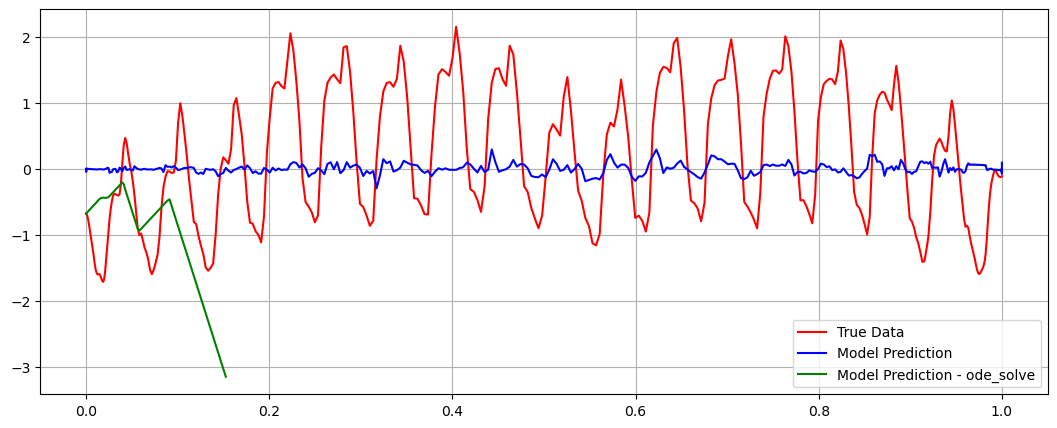

In [126]:
plt.figure(figsize=(13, 5))
plt.plot(t_train[offset : split], y_train_scaled[offset : split], 'r', label='True Data')
plt.plot(t_train[offset : split], u_model, 'b', label='Model Prediction')
plt.plot(t_train[offset : split][:100], ode_solution[:100], 'g', label='Model Prediction - ode_solve')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()